# Test of class Hamiltonian_QED



This notebook uses the class in 'Hamiltonian_QED_oprt.py' and 'Hamiltonian_QED_sym.py' that builds the Hamiltonian in terms of Pauli matrices.


In [17]:
import qiskit

from qiskit.quantum_info import Statevector
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys,os
import glob
sys.path.append("../../") # go to parent dir
from sympy import Symbol

from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz

from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf

### VQE results

In [18]:
#read result from picke file for VQDresult object

def read_data_from_file_pickle(filename):
    """It reads data from a file a VQDresult object."""
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"File '{filename}' does not exist.")

    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

In [19]:
entang_val='triangular'#'full'#

In [20]:
def read_vqe_results(entang_val):

    file_input=glob.glob('*'+entang_val+'*.pkl')[0]

    loaded_data=read_data_from_file_pickle(file_input)

    result =loaded_data['vqe_result']
    ed_data = loaded_data['ed_data']
    ed_plaq=loaded_data['ed_plaq']
    plaq_vqd=loaded_data['plaq_vqd']
    fid_vqd=loaded_data['fid']

    #e op dynamical fields for quantum circuit ordering
    e_op_free_input=loaded_data['string_list']
    e_op_free_input=[Symbol(e) for e in e_op_free_input]


    #class input parameters:
    n_sites=[int(file_input.split('2D_')[-1].split('m')[0][0]),int(file_input.split('2D_')[-1].split('m')[0][2])]
    magnetic_basis=eval(file_input.split('mbasis')[-1].split('_')[0])
    itr=int(file_input.split('_itr')[-1].split('_')[0])
    puregauge=eval(file_input.split('puregauge')[-1].split('_')[0])
    pbc=eval(file_input.split('pbc')[-1].split('_')[0])
    g=float(file_input.split('_g')[-1].split('_')[0])
    m=int(file_input.split('_m')[-1].split('_')[0])
    omega=int(file_input.split('_Omega')[-1].split('_')[0])
    optimizer=file_input.split('_optimizer')[-1].split('_')[0]
    fact_e_op = int(file_input.split('_factE')[-1].split('_')[0])
    fact_b_op = int(file_input.split('_factB')[-1].split('_')[0])
    l=int(file_input.split('_l')[-1].split('_')[0])
    L=2
    rotors = False
    lambd = 1000
    encoding = 'gray' #'ed'#
    static_charges_values =None
    display_hamiltonian=False
    e_op_out_plus=False #if E out of site n has plus sign 
    sparse_pauli=False
    #lattice
    latt = HCLattice(n_sites,pbc=pbc)

    # Creating a configuration dictionary with common inputs
    config = {
        'latt': latt,
        'n_sites': n_sites,
        'l':l,
        'L':L,
        'encoding':encoding,
        'magnetic_basis': magnetic_basis,
        'pbc': pbc,
        'puregauge': puregauge,
        'static_charges_values': static_charges_values,
        'e_op_out_plus': e_op_out_plus,
        'e_op_free_input':e_op_free_input
    }
    #Build Hamiltonian: essential to get the ansatz with correct order of dynamical links
    hamilt_sym = HamiltonianQED_sym(config)
    class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym,sparse_pauli=sparse_pauli)
    Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_e_op,lambd=0)


    return latt,class_H_oprt,Hamiltonian_Pauli_tot_vqd,result,ed_data,ed_plaq,plaq_vqd,fid_vqd

In [25]:
latt,class_H_oprt,Hamiltonian_Pauli_tot_vqd,result,ed_data,ed_plaq,plaq_vqd,fid_vqd=read_vqe_results(entang_val)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.007142305374145508 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 2.0821871757507324 seconds
>> Suppression term built.  Execution time: 0.002526998519897461 seconds


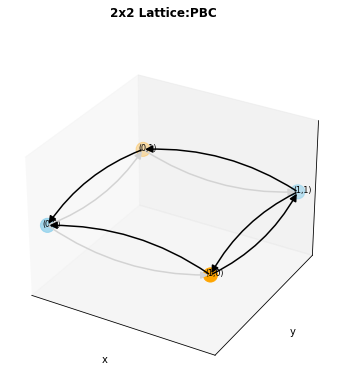

In [26]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [27]:
print('E_0(VQD)',result.eigenvalues[0].real,'E_0(ED)',ed_data,'plaq.(ED)',ed_plaq,'plaq.(VQD)',plaq_vqd,'fid',fid_vqd)

E_0(VQD) -0.7499354650252464 E_0(ED) -2.1821946002929336 plaq.(ED) 0.5731649282148258 plaq.(VQD) 0.3565531879851736 fid [0.2369613099366623]


E_0,VQD bind parameter -0.7495843643909679


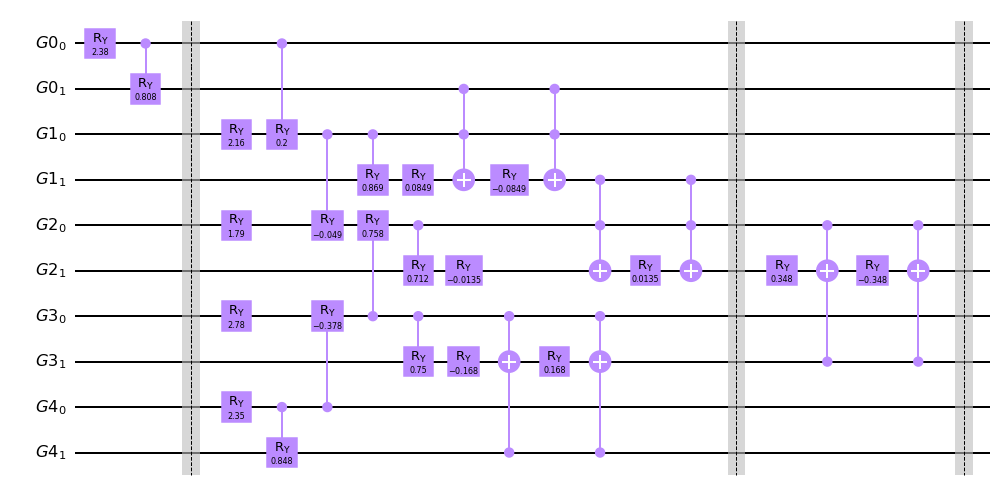

In [28]:
print('E_0,VQD bind parameter',Statevector(result.optimal_circuits[0].bind_parameters(result.optimal_parameters[0])).expectation_value(Hamiltonian_Pauli_tot_vqd).real)
result.optimal_circuits[0].bind_parameters(result.optimal_parameters[0]).draw('mpl',fold=60)